# Fitting ellipses to James Webb Space Telescope's cartwheel galaxy images

In [1]:
import Pkg

# activate parent environment
Pkg.activate(normpath(joinpath(@__DIR__, ".")))
Pkg.resolve()
Pkg.instantiate()
Pkg.status()

using Clustering
using Wavelets
using WaveletsExt

using Images
using ImageEdgeDetection
using ImageEdgeDetection: Percentile
using ImageFeatures
using Wavelets, LinearOperatorCollection
using RegularizedLeastSquares

using DSP
using Plots
using Statistics

using LinearAlgebra
using SCS
using JuMP

  Activating project at `c:\Users\lange\OneDrive - TU Eindhoven\master\2023-2024\2DME20 - NL optimization\project\2DME20-2023\project-2022-object-classification`
  No Changes to `C:\Users\lange\OneDrive - TU Eindhoven\master\2023-2024\2DME20 - NL optimization\project\2DME20-2023\project-2022-object-classification\Project.toml`
  No Changes to `C:\Users\lange\OneDrive - TU Eindhoven\master\2023-2024\2DME20 - NL optimization\project\2DME20-2023\project-2022-object-classification\Manifest.toml`


Status `C:\Users\lange\OneDrive - TU Eindhoven\master\2023-2024\2DME20 - NL optimization\project\2DME20-2023\project-2022-object-classification\Project.toml`
  [1e616198] COSMO v0.8.9
  [aaaa29a8] Clustering v0.15.7
⌅ [5ae59095] Colors v0.12.11
  [717857b8] DSP v0.7.10
  [5789e2e9] FileIO v1.16.6
  [87dc4568] HiGHS v1.12.1
  [2b14c160] ImageEdgeDetection v0.1.8
  [92ff4b2b] ImageFeatures v0.5.3
  [4e3cecfd] ImageShow v0.3.8
  [86fae568] ImageView v0.12.6
  [916415d5] Images v0.26.1
  [4076af6c] JuMP v1.23.5
  [a4a2c56f] LinearOperatorCollection v2.0.7
  [429524aa] Optim v1.10.0
⌃ [91a5bcdd] Plots v1.40.7
  [92933f4c] ProgressMeter v1.10.2
  [1e9c538a] RegularizedLeastSquares v0.16.6
  [c946c3f1] SCS v2.0.2
  [29a6e085] Wavelets v0.10.0
  [8f464e1e] WaveletsExt v0.2.2
Info Packages marked with ⌃ and ⌅ have new versions available. Those with ⌃ may be upgradable, but those with ⌅ are restricted by compatibility constraints from upgrading. To see why use `status --outdated`


## Read the image

Image size: (1024, 1024) - image dyadic size: (true, true)


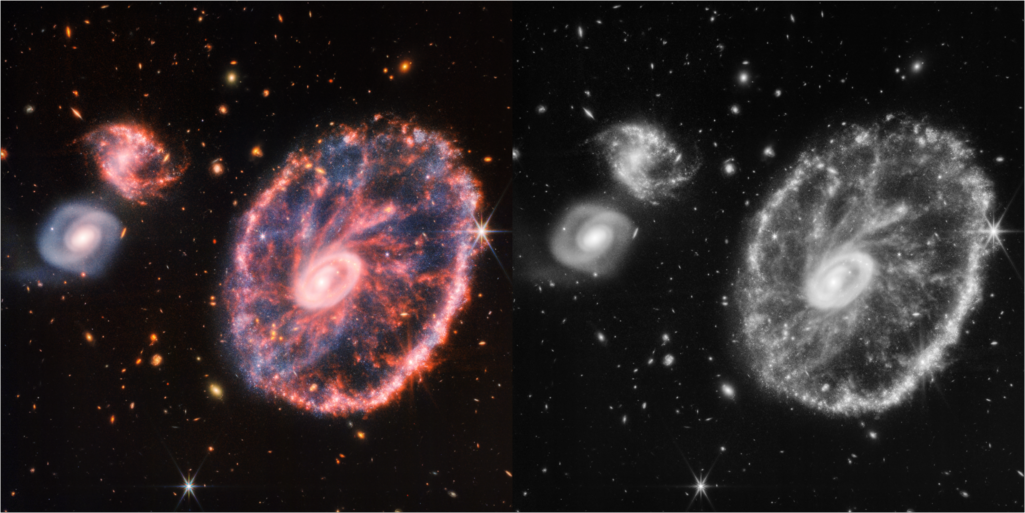

In [2]:
# read image (cartwheel galaxy)
directory_path = "."
image_path = joinpath(directory_path, "cartwheel_galaxies_JWST.png")
img = load(image_path)
println("Image size: ", size(img), " - image dyadic size: ", isdyadic.(size(img)))

# convert image to gray scale
img_gray = Gray.(img)
mosaicview(img, img_gray; nrow=1)

Image size: (256, 256) - image dyadic size: (true, true)


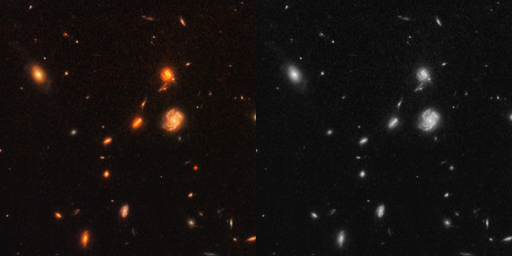

In [3]:
# select a region of interest
sz = 256
X_c = 600
Y_c = 140

X = X_c:X_c+sz-1
Y = Y_c:Y_c+sz-1
roi = (X, Y)

# plot the region of interest
img_roi = img[roi...]
img_gray_roi = img_gray[roi...]
println("Image size: ", size(img_roi), " - image dyadic size: ", isdyadic.(size(img_roi)))
mosaicview(img_roi, img_gray_roi; nrow=1)

## Helper functions

In [4]:
function plot_dwt(x, sz=(500, 500))
    plt = heatmap(x, color=:grays, aspect_ratio=1, cbar=false,
        xlims=(0, size(x, 2)),
        ylims=(0, size(x, 1)),
        size=sz,
        dpi=300
    )
end

function flip(x)
    return x[end:-1:1, :]
end

function normalize(x)
    x = (x .- minimum(x)) ./ (maximum(x) - minimum(x))
    return x
end

normalize (generic function with 1 method)

## Wavelet sparsification

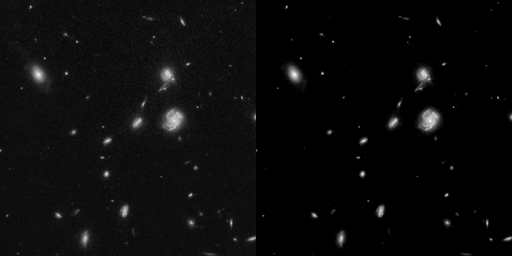

In [5]:
x = convert(Array{Float64}, img_gray_roi)

# total variation regularization
reg = L1Regularization(0.1);

# wavelet operator matrix A
A = WaveletOp(Float64, shape=size(x), wt=wavelet(WT.coif4));

# build optimization solver
solver = createLinearSolver(OptISTA, A; reg=reg, iterations=10);

# sampled image in wavelet domain
b = A * vec(x);

x_approx = solve!(solver, b)
x_approx = reshape(x_approx, size(x));

x_final = normalize(x_approx)

mosaicview(x, Gray.(x_final); nrow=1)

## Binarization

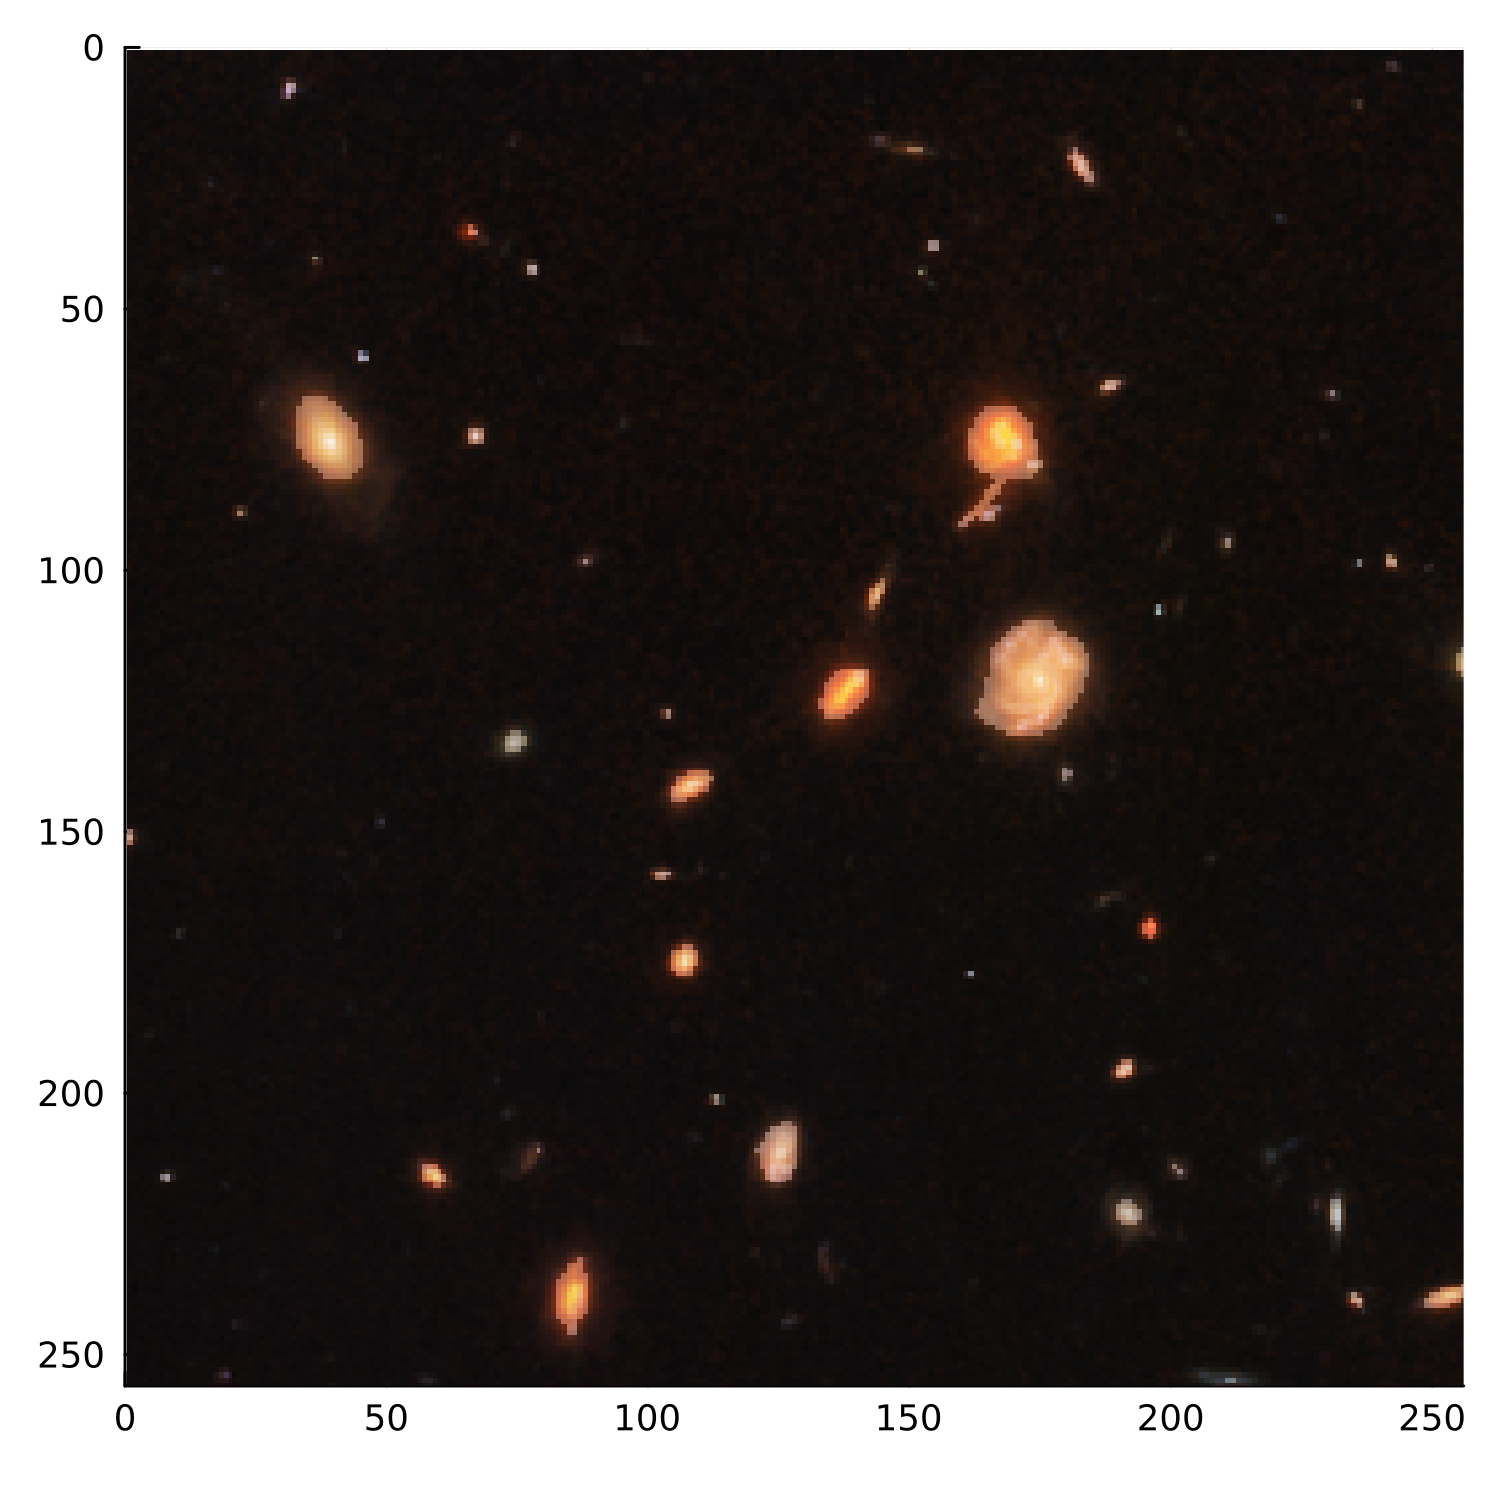

In [6]:
# binarization
x̂_bin = binarize(x_final, Otsu(); nbins=128)
x̂_bin = convert(Array{Bool}, x̂_bin)

plt = plot_dwt(img_roi, (500, 500))
heatmap!(x̂_bin, color=:grays, alpha=0.25)

## Clustering

In [7]:
function edge_detector(f_smooth::Matrix{Float64}, d1::Float64=0.1, d2::Float64=0.1)
    # Dimensions of the image
    rows, cols = size(f_smooth)

    # Preallocate arrays for gradient and Laplacian
    gradient_magnitude = zeros(Float64, rows, cols)
    laplacian_magnitude = zeros(Float64, rows, cols)
    edge_matrix = zeros(Bool, rows, cols)  # Binary matrix for edges

    # Sobel filters
    sobel_x = [-1 0 1; -2 0 2; -1 0 1]
    sobel_y = [-1 -2 -1; 0 0 0; 1 2 1]
    sobel_xx = [-1 2 -1; 2 -4 2; -1 2 -1]
    sobel_yy = [-1 2 -1; 2 -4 2; -1 2 -1]

    # Convolve the image with the Sobel filters
    gradient_x = conv(f_smooth, sobel_x)
    gradient_y = conv(f_smooth, sobel_y)

    # Compute the gradient magnitude
    gradient_magnitude = sqrt.(gradient_x .^ 2 + gradient_y .^ 2)

    # second derivative
    gradient_xx = conv(f_smooth, sobel_xx)
    gradient_yy = conv(f_smooth, sobel_yy)
    laplacian_magnitude = sqrt.(gradient_xx .^ 2 + gradient_yy .^ 2)

    # thresholding with d1, d2
    for i in 1:rows
        for j in 1:cols
            if gradient_magnitude[i, j] > d1 && laplacian_magnitude[i, j] < d2
                edge_matrix[i, j] = true
            end
        end
    end

    return edge_matrix, gradient_magnitude, laplacian_magnitude
end

edge_detector (generic function with 3 methods)

In [8]:
points = Vector{Vector{Int}}()
for i in 1:size(x̂_bin, 1)
    for j in 1:size(x̂_bin, 2)
        if x̂_bin[i, j]
            push!(points, [i, j])
        end
    end
end

points = hcat(points...)
points = convert(Matrix{Float64}, points)

# DBSCAN clustering
result = dbscan(points, 2.0, min_neighbors=2, min_cluster_size=15)

# convert points back to Int
points = convert(Matrix{Int}, points)

2×1189 Matrix{Int64}:
  7   7   8   8   9   19   19   19   19  …  244  245  245  246  246  255  255
 31  32  31  32  31  150  151  152  182      86   85   86   85   86  211  212

In [9]:
clusters = result.clusters
N_clusters = length(clusters)
colors = distinguishable_colors(N_clusters);

In [10]:
canny(x, d1, d2) = edge_detector(Matrix{Float64}(x), d1, d2)[1]

canny (generic function with 1 method)

In [ ]:
# # prepare a cluster result struct
# struct Cluster
#     edge_indices::Vector{Int}
#     core_indices::Vector{Int}
#     core_points::Vector{Vector{Int}}
#     edge_points::Vector{Vector{Int}}
#     color::RGB{N0f8}
# end

# cluster_results = Cluster[]

# for (i, cluster) in enumerate(clusters)
#     core_indices = cluster.core_indices
#     core_points = points[:, core_indices]
#     x_bin_cluster = x̂_bin[core_points[1, :], core_points[2, :]]
#     # println(x_bin_cluster)

#     # # edge detection
#     # edges = canny(core_points, 1e-1, 1e2)
#     # edges = thinning(edges, algo=GuoAlgo())
#     # edge_indices = findall(edges)
#     # println("Cluster $i - core points: ", length(core_indices), " - edge points: ", length(edge_indices))
# end

# # Plot the points with the colors of the clusters
# plt = plot_dwt(img_roi, (500, 500))

# for (i, cluster) in enumerate(clusters)
#     p_cluster = points[:, cluster.core_indices]
#     scatter!(p_cluster[2, :], p_cluster[1, :],
#             color=colors[i],
#             label="Cluster $i",
#             markerstrokewidth=0,
#             markersize=2
#     )
# end

# # Display the plot
# plot!(plt,
#     axis=false,
#     legend=false,
# )

## Canny edge detection

In [13]:
# # canny
# canny(x, d1, d2) = edge_detector(Matrix{Float64}(x), d1, d2)[1]
# edges = canny(1e-1, 1e2)
# edges = thinning(edges, algo=GuoAlgo());
# # edges = clearborder(edges, 10);
# plot_dwt(flip(edges))